# Convex Polygon Extraction from Images

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Imports

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math
import matplotlib.image as mpimg
from scipy.ndimage import convolve

In [3]:
def load_image(path): return mpimg.imread(path)
def plot_image(img): plt.imshow(img, cmap=plt.get_cmap('gray'))

In [4]:
IMG_SIZE = (16, 16)

## Introduction

Let's take the iconic image of a teapot. The goal is to find the convex polygon which contains the teapot.

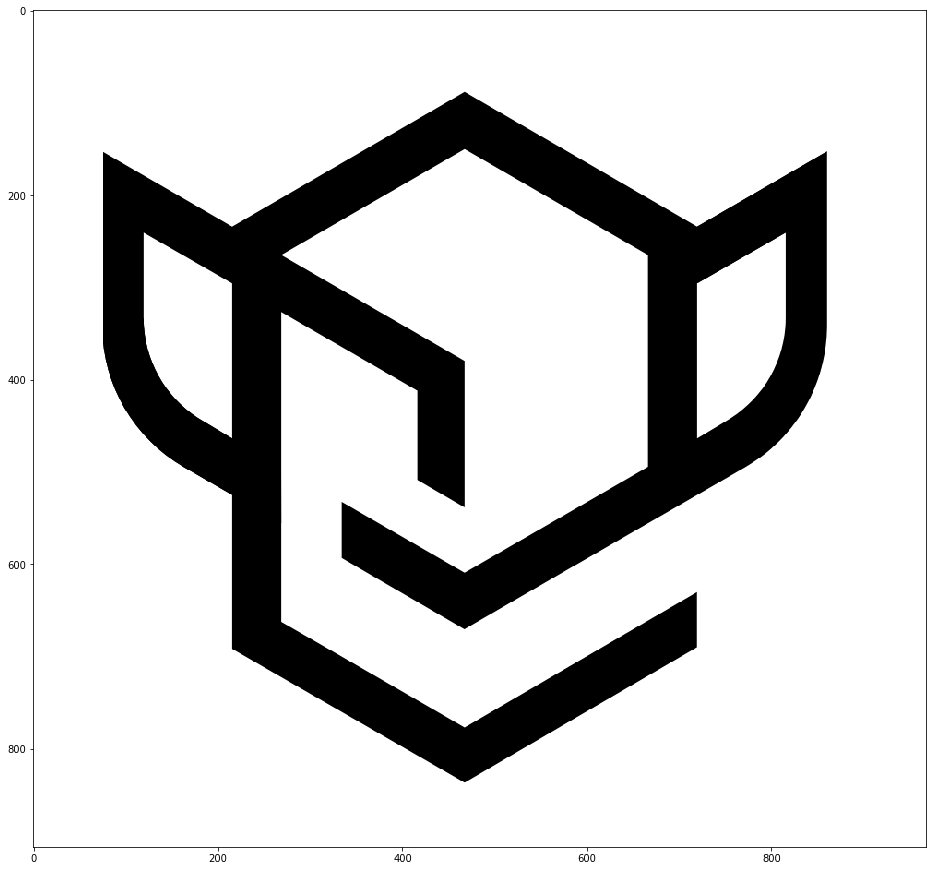

In [23]:
teapot = load_image('elfsquad.png')
plt.figure(figsize=IMG_SIZE)
plt.imshow(teapot);

To find this convex polygon, the following steps are performed:

  1. Convert the image into grayscale.
  2. Apply a smoothing with a Gaussian kernel.
  3. Calculate a 2D spatial gradient measurement.
  4. Threshold the image.
  5. Extract points from the image.
  6. Determine the convex hull for these points.

# Converting to grayscale

To transform the $(r, g, b)$ values into a single value, the following formula is used:

$$ Y' = 0.2989R + 0.5870G + 0.1140B $$

In [24]:
def rgb2gray(rgb): return np.dot(rgb[...,:3], [0.2989, 0.587, 0.114])

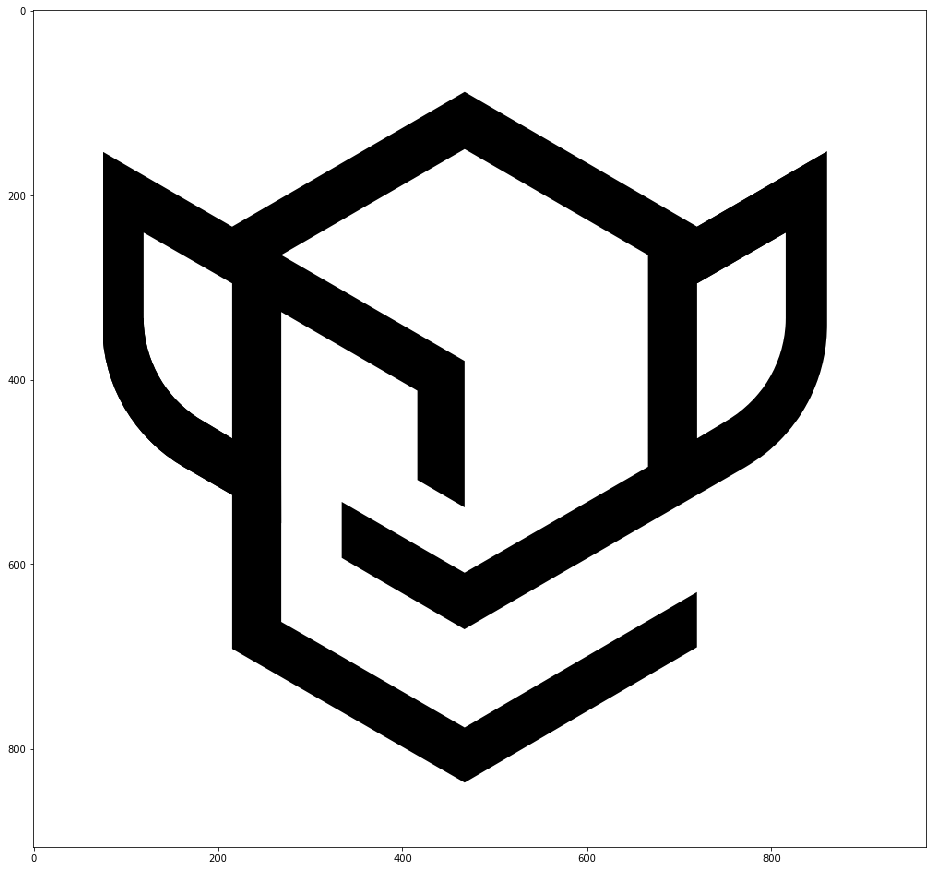

In [25]:
teapot_gray = rgb2gray(teapot)

plt.figure(figsize=IMG_SIZE)
plot_image(teapot_gray)

Because the values are betwee $[0, 255]$, we also normalize the values to be in the range of $[0, 1]$.

In [26]:
teapot_gray = teapot_gray / 255
print('Min value: {}, Max value {}'.format(np.min(teapot_gray), np.max(teapot_gray)))

Min value: 0.0, Max value 0.003921176470588235


# Smoothing with a Gaussian kernel

The image is smoothed with a Gaussian kernel to remove remove any spikes from the data.

In [27]:
G = 1 / 273 * np.matrix([[1, 4 , 7 , 4 , 1],
                         [4, 16, 26, 16, 4],
                         [7, 26, 41, 26, 7],
                         [4, 16, 26, 16, 4],
                         [1, 4 , 7 , 4 , 1]]) 

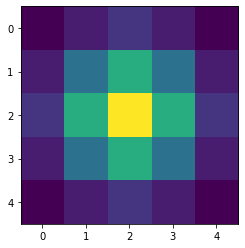

In [28]:
plt.imshow(G)

Min value: 0.0, Max value 0.003921176470588234


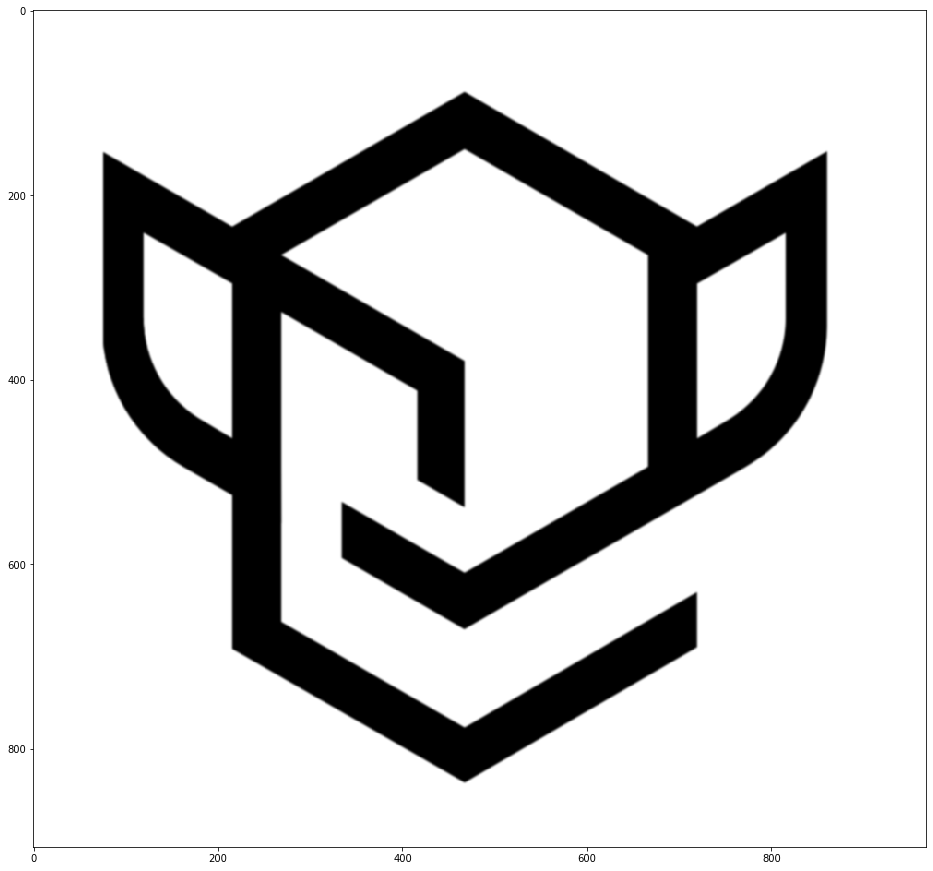

In [29]:
teapot_gray_smooth = convolve(teapot_gray, G)

plt.figure(figsize=IMG_SIZE)
plot_image(teapot_gray_smooth)
print('Min value: {}, Max value {}'.format(np.min(teapot_gray_smooth), np.max(teapot_gray_smooth)))

## 2D Spatial Gradient Measurements

The Sobel operator is used to determine the spatial gradient measurements of the teapot. From this the edged teapot will be determined.

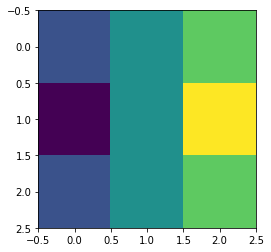

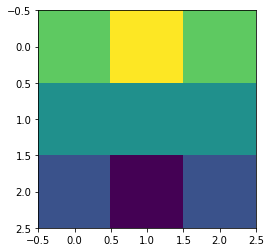

In [30]:
Gx = np.matrix([[-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1]])

Gy = np.flip(Gx.T)

imshow(Gx)
show()
imshow(Gy)

This image contains the spatial information in the x direction. It goes up to a value of 2 when there is an edge, and when it leaves that edge it goes down to a value of -2.

Min value: -0.009939392372333548, Max value 0.00993939237233355


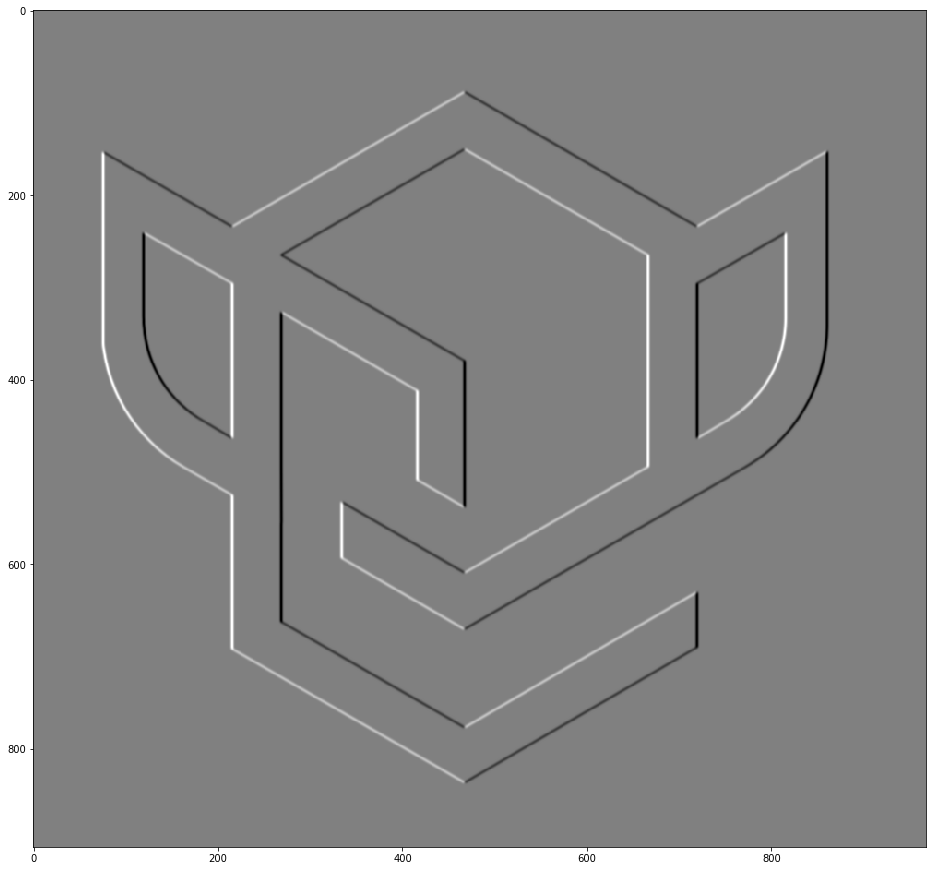

In [31]:
teapot_dx = convolve(teapot_gray_smooth, Gx)
print('Min value: {}, Max value {}'.format(np.min(teapot_dx), np.max(teapot_dx)))
plt.figure(figsize=IMG_SIZE)
plot_image(teapot_dx)

This is the same image, but then in the y-direction.

Min value: -0.00959411030258451, Max value 0.009660012423356424


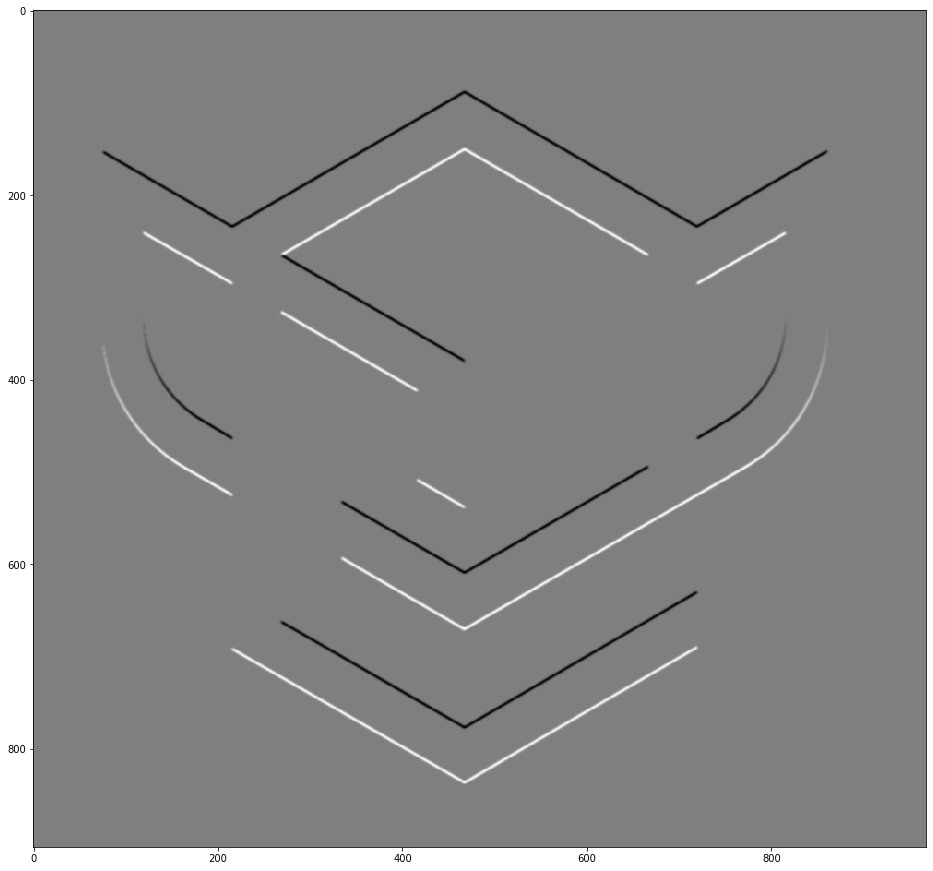

In [32]:
teapot_dy = convolve(teapot_gray_smooth, Gy)
print('Min value: {}, Max value {}'.format(np.min(teapot_dy), np.max(teapot_dy)))
plt.figure(figsize=IMG_SIZE)
plot_image(teapot_dy)

The edges are located at values of -2 and 2, so if we take the absolute value, all the edges have positive values, while the rest is 0.

Min value: 0.0, Max value 0.014219650937297997


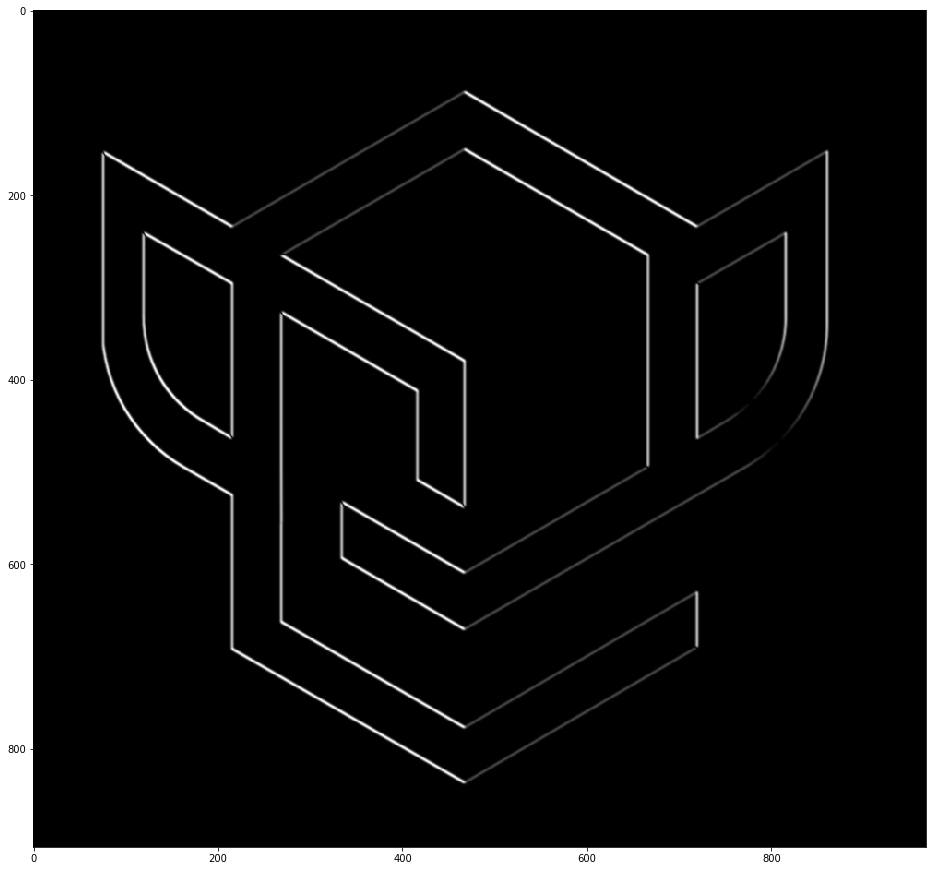

In [33]:
teapot_edged = abs(teapot_dx + teapot_dy)
print('Min value: {}, Max value {}'.format(np.min(teapot_edged), np.max(teapot_edged)))
plt.figure(figsize=IMG_SIZE)
plot_image(teapot_edged)

## Thresholding the image

With the values between $[0, 2.718]$, we are going to threshold the values with the following function:

$$ 
T(x, t_1, t_2) = 
\begin{cases}
1 \quad \text{if}\ t_1 < x < t_2 \\
0 \quad \text{otherwise}
\end{cases}
$$

In [34]:
teapot_threshold = None

interactive(children=(FloatSlider(value=0.0005, description='t1', max=0.0015, min=-0.0005), IntSlider(value=1,…

Min value: 0, Max value 1


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

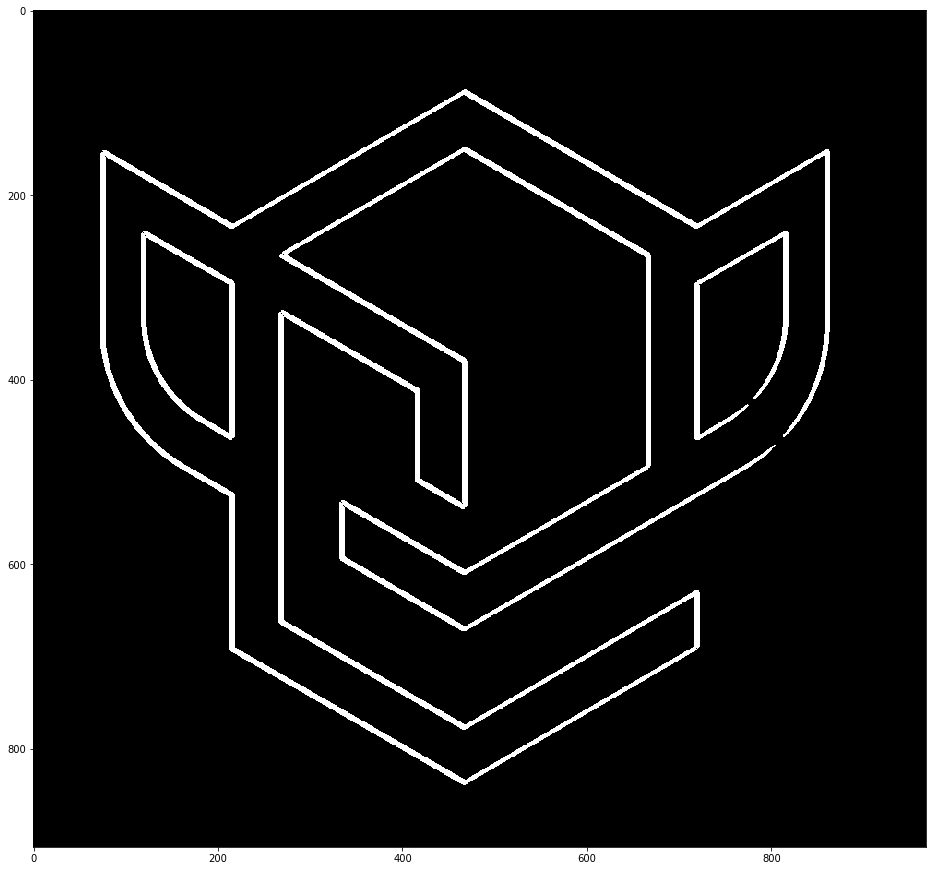

In [41]:
@interact
def threshold(t1=0.0005, t2=1):
    global teapot_threshold
    teapot_threshold = np.vectorize(lambda x: 1 if t1 < x < t2 else 0)(teapot_edged)
    print('Min value: {}, Max value {}'.format(np.min(teapot_threshold), np.max(teapot_threshold)))
    plt.figure(figsize=IMG_SIZE)
    plot_image(teapot_threshold)
    return teapot_threshold
threshold()

## Extract Points

All the remaining values of the image are now either 0 for nothing, and 1 for an edge. Now we are going to extract points from the image. This is not really efficient though. Because there are a lot of pixels, we only take every 16th pixel based on the x-axis, which needs to be sorted.

In [42]:
P = []
for x in range(teapot_threshold.shape[0]):
    for y in range(teapot_threshold.shape[1]):
        if teapot_threshold[x, y] > 0.1:
            P.append((y, x))
P = sorted(P, key=lambda x: x[0])

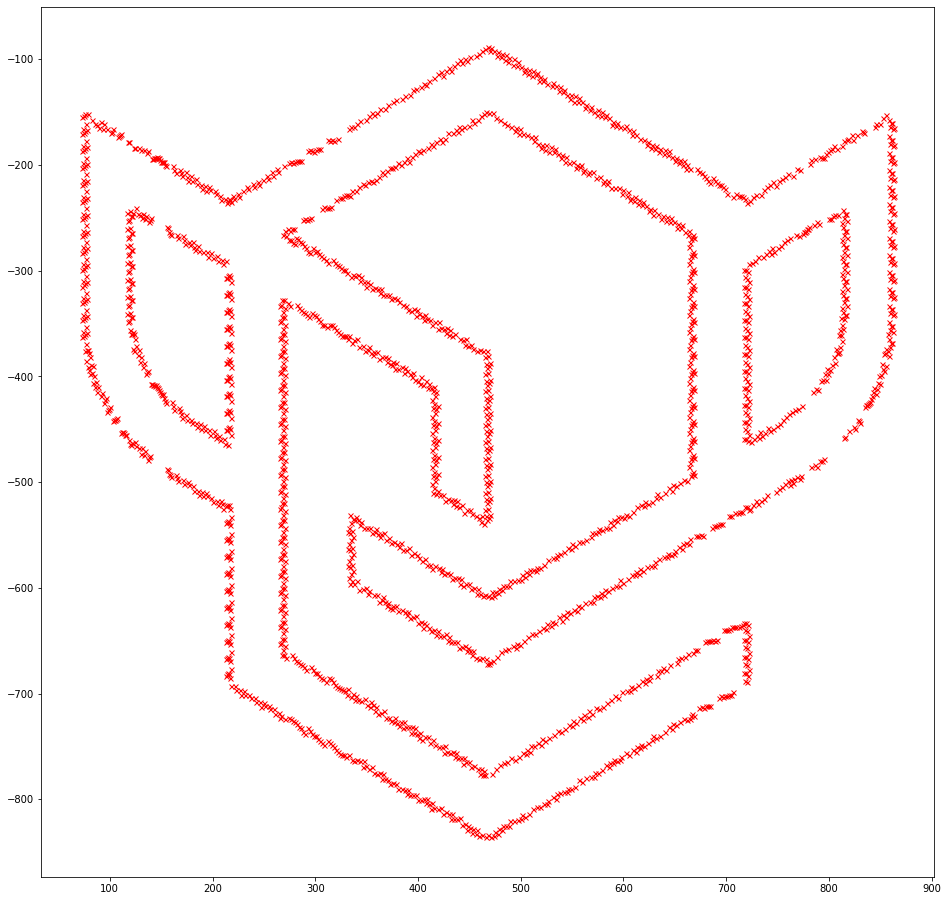

In [43]:
sparsity = 16
x, y = zip(*P[0::sparsity])
plt.figure(figsize=IMG_SIZE)
plot(x, -np.array(y), 'o', ms=5, c='red', marker='x')

This gives us a set of points for which we can find the convex hull.

# Convex Hull

The convex hull $\mathcal{CH}(P)$ of a set of points $P$ is the convex polygon that contains all the points $P$. [The algorithm and a demo is here.](https://darkeclipz.github.io/compgeo/convex-hull.html). It will be applied to the set of points that we extracted from the image.

In [44]:
def det2(a, b, c, d): return a * d - b * c
def is_right_turn(p1, p2, p3): return det2(p1[0] - p2[0], p1[1] - p2[1], p3[0] - p2[0], p3[1] - p2[1]) >= 0

In [45]:
def convex_hull(P):
    n = len(P)
    sorted(P, key=lambda p: p[0])
    L_upper = [P[0], P[1]]
    for i in range(2, n):
        L_upper.append(P[i])
        while len(L_upper) > 2 and not is_right_turn(*L_upper[-3:]):
            del L_upper[-2]
    L_lower = [P[-1], P[-2]]
    for i in range(n - 2, 0, -1):
        L_lower.append(P[i])
        while len(L_lower) > 2 and not is_right_turn(*L_lower[-3:]):
            del L_lower[-2]
    return L_upper + L_lower

<Figure size 720x720 with 0 Axes>

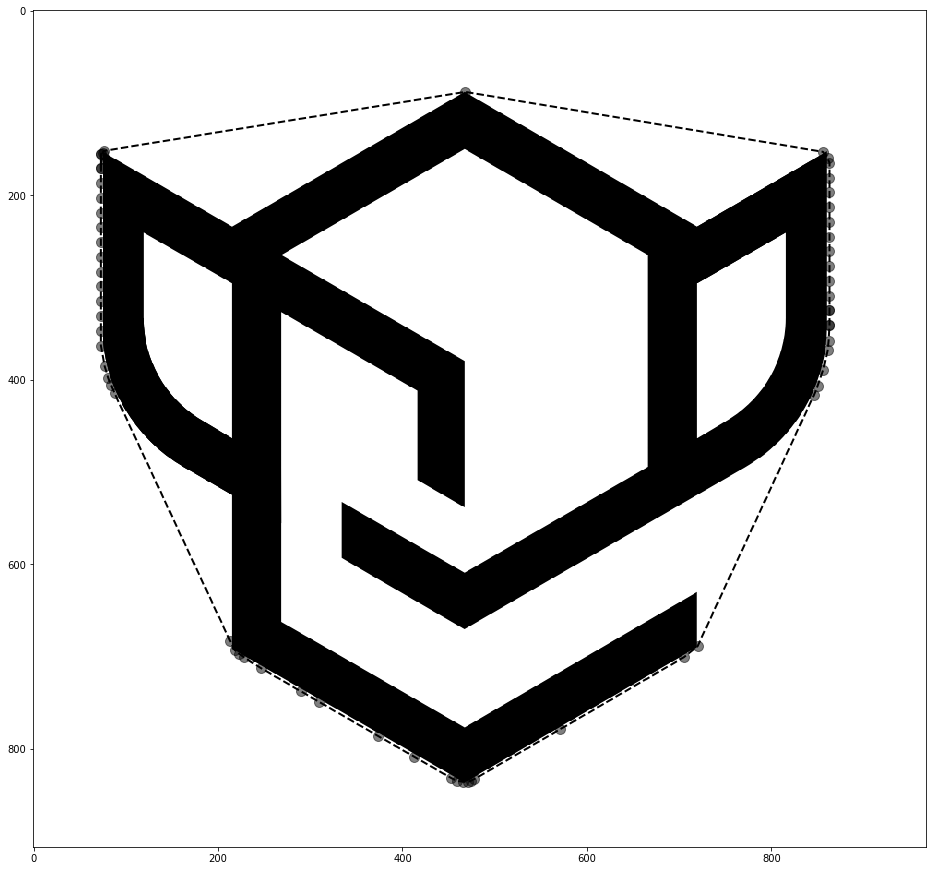

In [46]:
CH = convex_hull(list(zip(x, y)))
CH.append(CH[0])  # close the loop
chx, chy = zip(*CH)

plt.figure(figsize=(10,10))
figure(figsize=IMG_SIZE)
plot(chx, chy, c='black', lw=2, ls='dashed')
plt.imshow(teapot)
plt.plot(chx, chy, 'o', c='black', ms=10, alpha=0.5)

# Resources

1. http://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter5.pdf

2. https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

3. https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

4. https://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm

5. https://homepages.inf.ed.ac.uk/rbf/HIPR2/roberts.htm